## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimage

#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration1*.jpg')
print(images)
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #print(corners)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    #print(gray.shape[::-1])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

#rint("Here")
#for fname in images:
#    img = cv2.imread(fname)
#    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    #cv2.imshow(fname,undist)
    #print("Test")
    #break
    #cv2.waitKey(500)
# Draw and display the corners
#img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#cv2.imshow('img',img)
#cv2.waitKey(500)
#cv2.destroyAllWindows()

['camera_cal/calibration1.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration19.jpg']


## And so on and so forth...

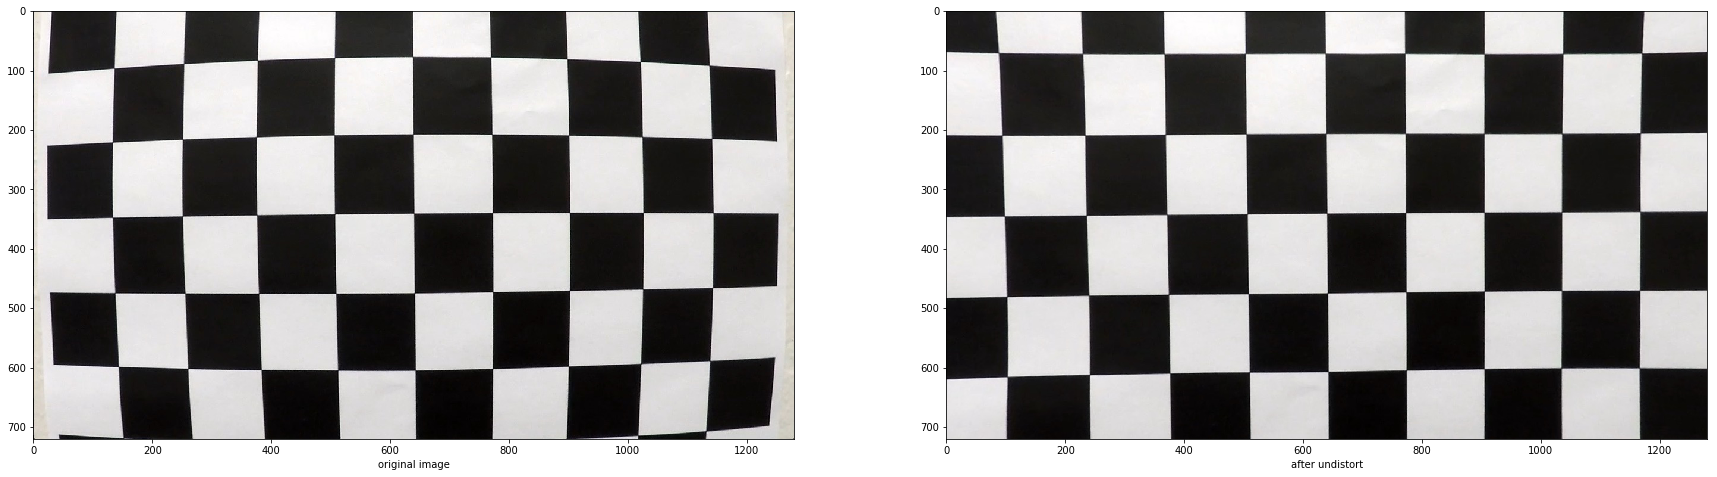

In [10]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
%matplotlib inline

#%matplotlib qt

calibrate_params_file = 'c_params.p.npz'

def calibrate_from_chessboard_images():
    objp = np.zeros((6*9,3), np.float32)
    objp[:, :2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    fimages = glob.glob('camera_cal/calibration*.jpg')
    for fname in fimages:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    np.savez_compressed(calibrate_params_file, mtx=mtx, dist=dist) 
    return mtx, dist

def load_calibrate_params():
    data = np.load(calibrate_params_file)
    return data['mtx'], data['dist']


#calibrate_from_chessboard_images()
mtx, dist = load_calibrate_params()
plt.figure(figsize=(30, 30))
image = mpimage.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('original image')

plt.subplot(1, 2, 2)
plt.imshow(undist)
plt.xlabel('after undistort')
plt.show()


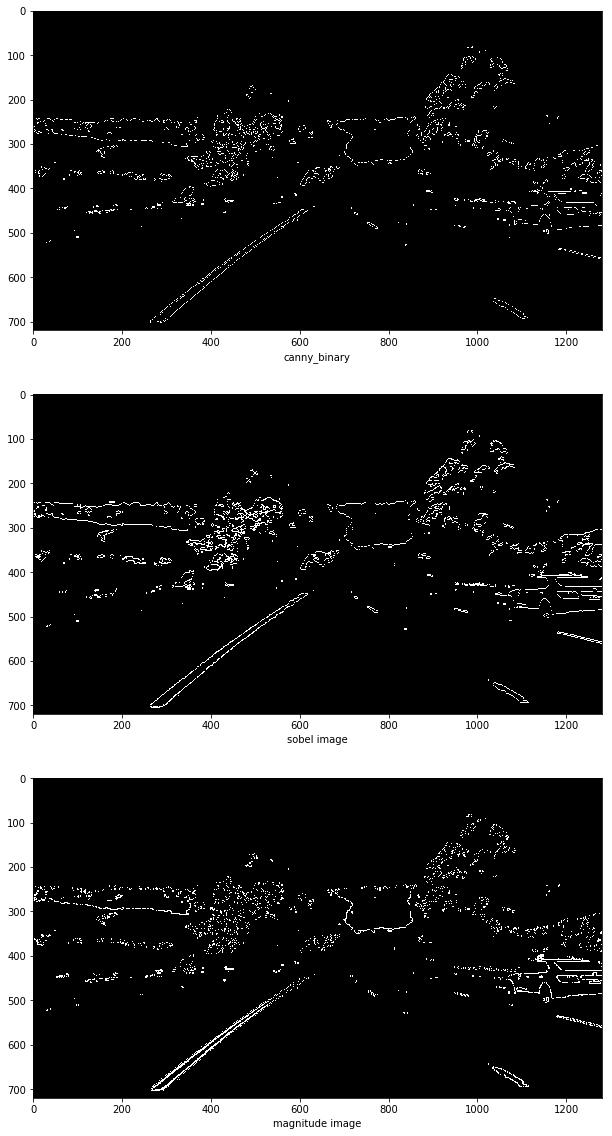

In [32]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    magnitude_scale = np.uint8(255*magnitude/np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(magnitude_scale)
    binary_output [(magnitude_scale >= mag_thresh[0]) & (magnitude_scale <= mag_thresh[1])] =1
    return binary_output

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    #return scaled_sobel
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def filter_by_color(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    blur_img = gaussian_blur(hsv_img, 5)
    yellow_min = np.array([65, 80, 80], np.uint8)
    yellow_max = np.array([105, 255, 255], np.uint8)
    yellow_mask = cv2.inRange(blur_img, yellow_min, yellow_max);
    
    white_min = np.array([0, 0, 220], np.uint8)
    white_max = np.array([255, 80, 255], np.uint8)
    white_mask = cv2.inRange(blur_img, white_min, white_max)
    #white_mask = np.zeros_like(yellow_mask)
    blur_img = cv2.bitwise_and(blur_img, blur_img, mask=cv2.bitwise_or(yellow_mask, white_mask))
    return blur_img

    
kernel_size = 5 
low_threshold = 50
high_threshold = 150
    
mtx, dist = load_calibrate_params()
plt.figure(figsize=(20, 20))
image = mpimage.imread('test_images/test1.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
undist = filter_by_color(undist)
canny_binary = canny(undist, low_threshold, high_threshold)
sobel_binary = abs_sobel_thresh(undist, 20, 50)
mag_binary = mag_thresh(undist, 3, (30, 120))


plt.subplot(3, 1, 1)
plt.imshow(canny_binary, cmap='gray')
plt.xlabel('canny_binary')

plt.subplot(3, 1, 2)
plt.imshow(sobel_binary, cmap='gray')
plt.xlabel('sobel image')

plt.subplot(3, 1, 3)
plt.imshow(mag_binary, cmap='gray')
plt.xlabel('magnitude image')

plt.show()

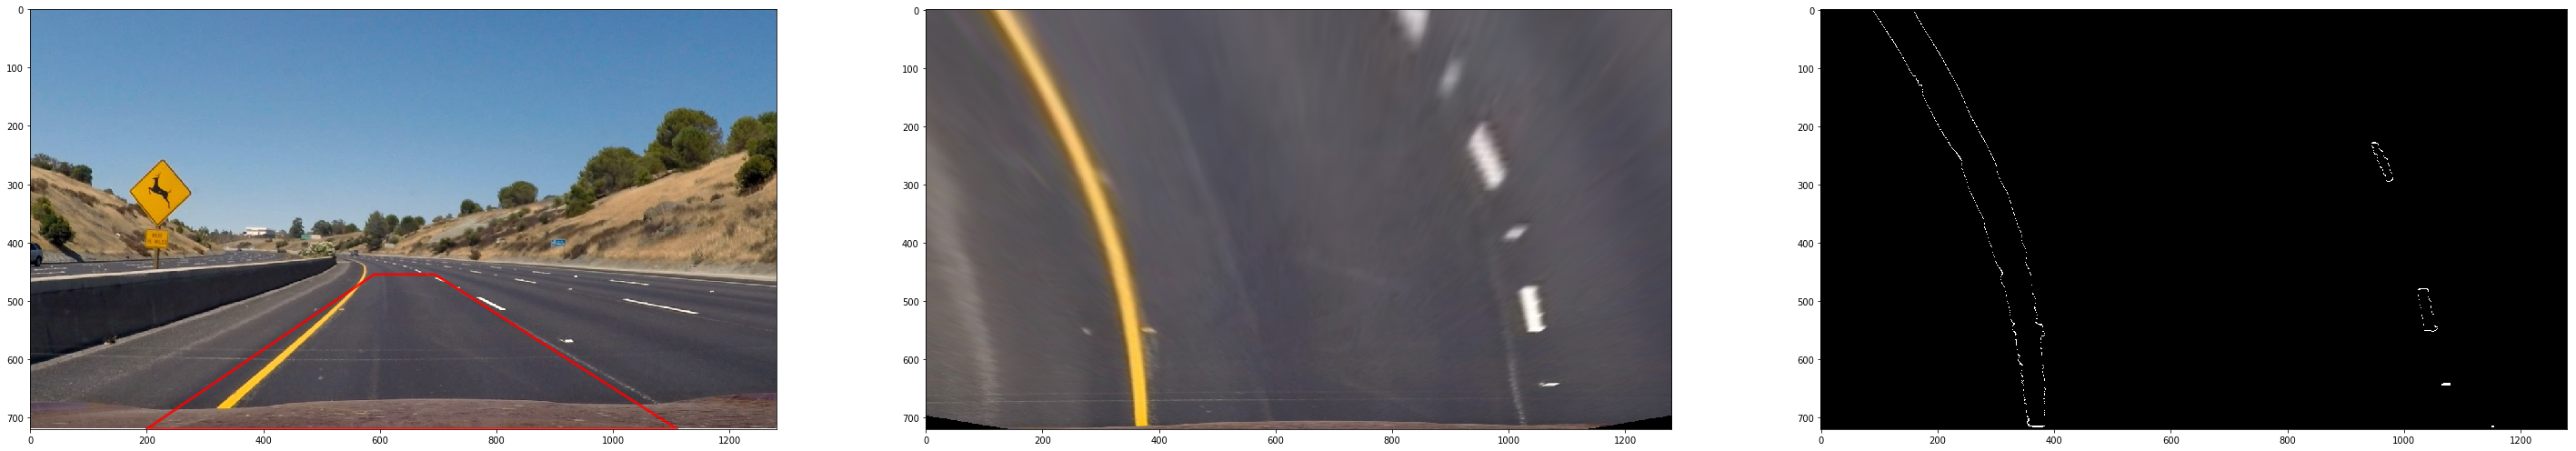

In [58]:
def warp_img(img, src, dst):
    y,x = img.shape[:2]
    M =  cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (x,y), flags=cv2.INTER_LINEAR)
    return warped, M, Minv


#image = mpimage.imread('test_images/straight_lines1.jpg')
image = mpimage.imread('test_images/test2.jpg')
mtx, dist = load_calibrate_params()
undist = cv2.undistort(image, mtx, dist, None, mtx)
h, w = undist.shape[:2]

src = np.float32([(590.0 /1280. * w,  455. / 720. * h),
                  (695.0 /1280. * w,  455. / 720. * h),
                  (1110.0 / 1280. * w, 1. * h),
                  (200.0 / 1280. * w, 1. * h)])

dst = np.float32([(300.0 /1280. * w,  100. / 720. * h),
                  (1000.0 /1280. * w, 100. / 720. * h),
                  (1000.0 / 1280. * w, 1. * h),
                  (300.0 / 1280. * w, 1. * h)])

wraped_img, M, Minv = warp_img(undist, src, dst)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(50,50))
ax1.imshow(image)
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
ax1.plot(x, y, color='#ff0000', alpha=0.8, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])

#canny_img = canny(filter_by_color(wraped_img), low_threshold, high_threshold)
canny_binary = canny(undist, low_threshold, high_threshold)
#canny_img = abs_sobel_thresh(filter_by_color(wraped_img), 20, 50)
#mag_binary = mag_thresh(undist, 3, (30, 120))

ax2.imshow(wraped_img, cmap='gray')
ax3.imshow(canny_img, cmap='gray')


464.029417969 1039.36023625 -0.472212664117


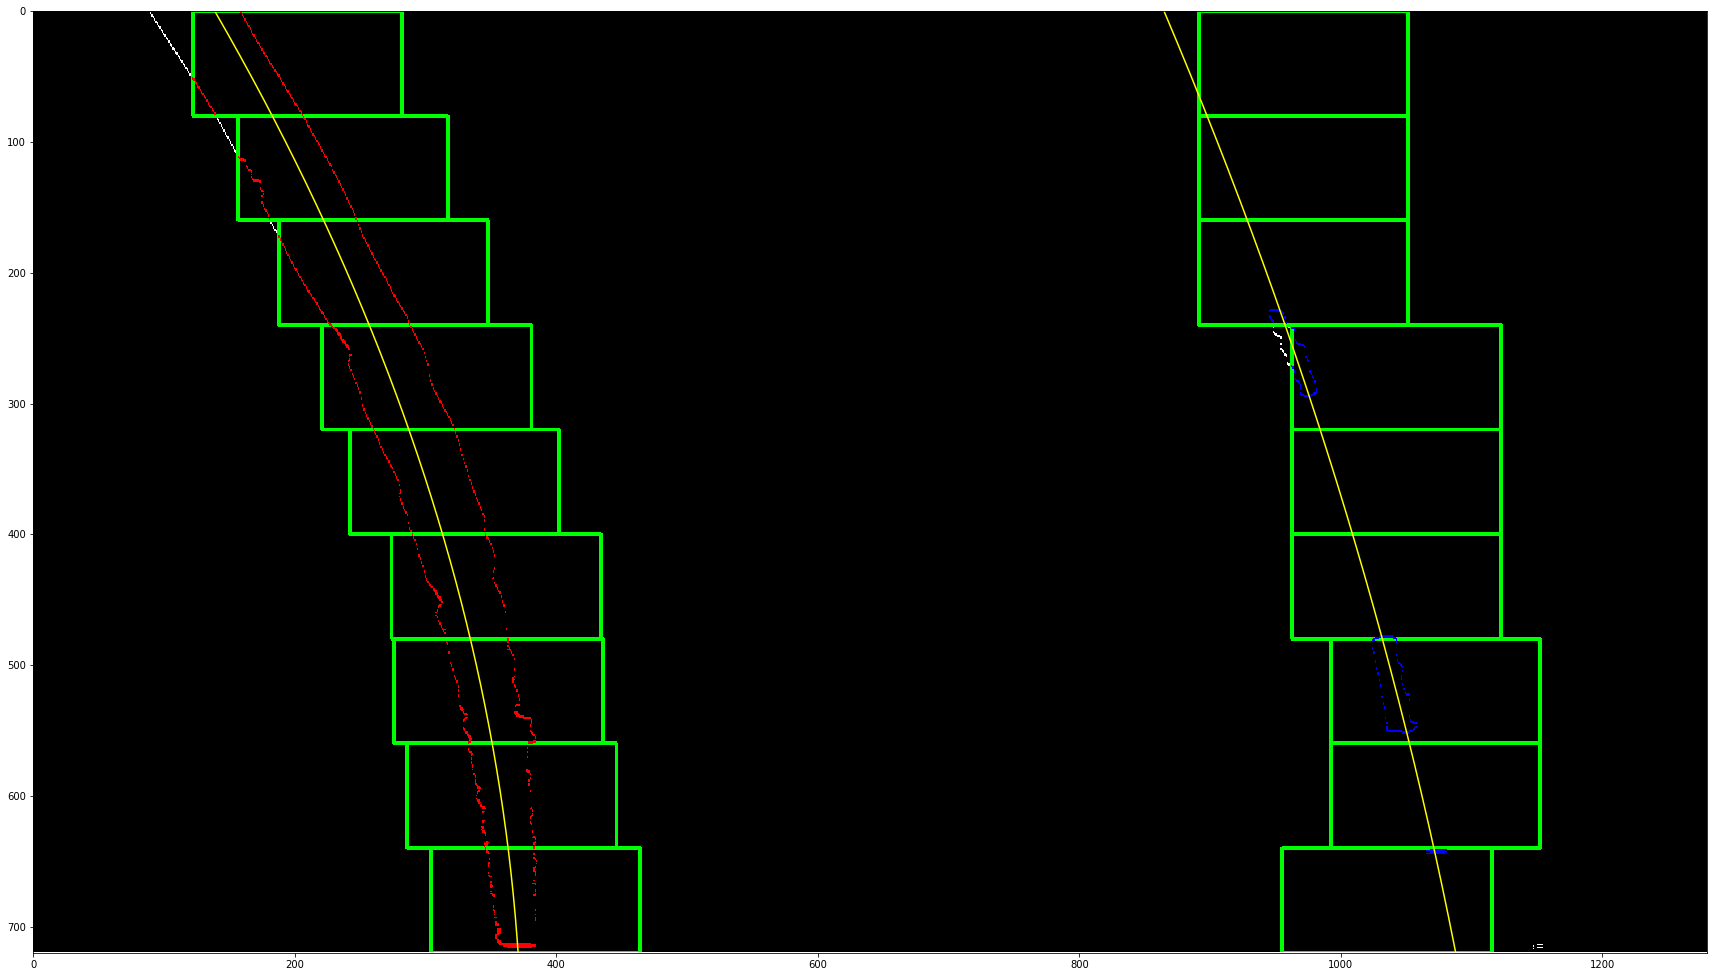

In [59]:
def fine_lane_by_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

def fine_lanes_by_cur_img(binary_warped):
    histogram = np.sum( binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit, right_fit = None, None
    if len(leftx) > 1:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) > 1:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img

def find_lanes(binary_warped, left_fit_prev= None, right_fit_prev = None, draw_pic= False):
    left_fit, right_fit, left_lane_inds, right_lane_inds = None, None, None, None
    out_img = None
    if left_fit_prev is not None and right_fit_prev is not None:
        left_fit, right_fit, left_lane_inds, right_lane_inds = fine_lane_by_prev_fit(binary_warped, left_fit_prev, right_fit_prev)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds,out_img = fine_lanes_by_cur_img(binary_warped)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # calculate curvature and car center dist
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    y_eval = 719
    left_curverad = None
    right_curverad = None
    center_dist = 0
    if left_fit is not None and right_fit is not None:
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        h = binary_warped.shape[0]
        car_position = binary_warped.shape[1]/2
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    
    # show it
    if draw_pic and out_img is not None:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.subplots(figsize=(30,30))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return left_fit,right_fit,left_curverad, right_curverad,center_dist

left_fit, right_fit, left_curverad, right_curverad, center_dist = find_lanes(canny_img, draw_pic= True)
print(left_curverad, right_curverad, center_dist)

#print(canny_img.nonzero())

464.029417969 1039.36023625


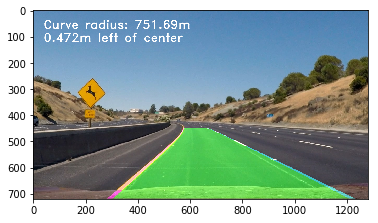

In [63]:

def draw_lane(original_img, binary_img, l_fit, r_fit, Minv, left_curverad, right_curverad, center_dist):
    new_img = np.copy(original_img)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    h,w = binary_img.shape
    if l_fit is not None and r_fit is not None:
        ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
        left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
        right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    
    # draw test curvature and center dist
    mid_curverad = 0
    print (left_curverad,right_curverad)
    if left_curverad is not None and right_curverad is not None:
        mid_curverad = (left_curverad + right_curverad)/2
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(mid_curverad) + 'm'
    cv2.putText(result, text, (40,70), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(result, text, (40,120), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return result
plt.subplots(figsize=(30,30))
plt.imshow(draw_lane(image, canny_img, left_fit, right_fit, Minv, left_curverad, right_curverad, center_dist))


1548.5811706 529.533196811


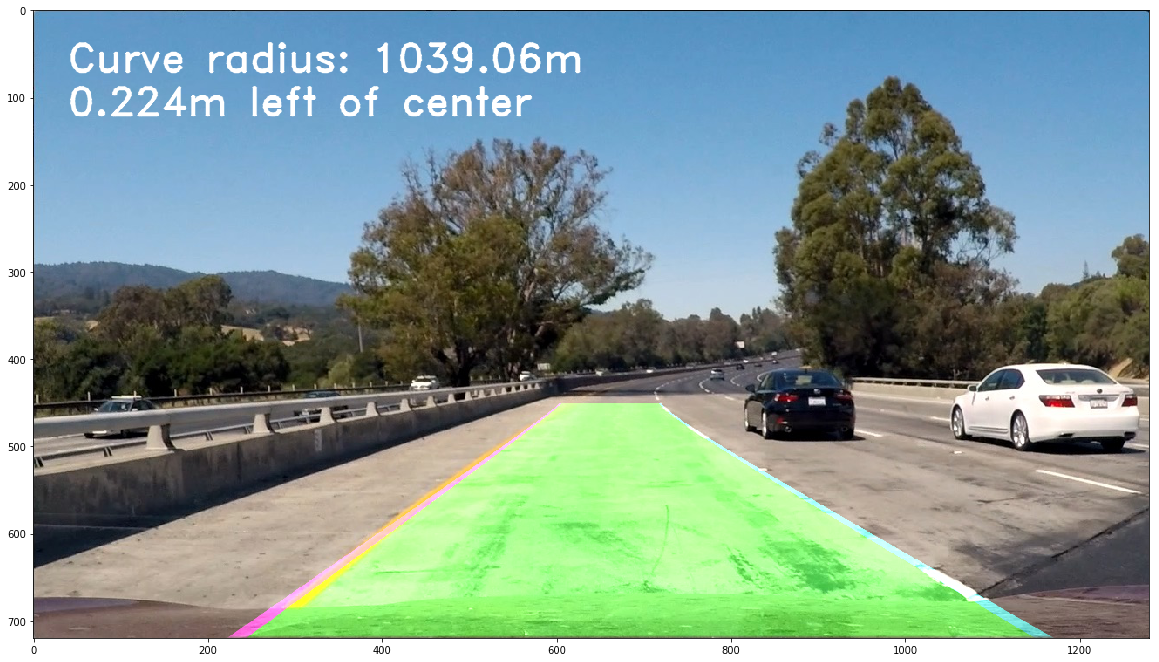

In [64]:
pre_left_fit, pre_right_fit = None, None
def pipeline(cur_image, use_pre = True):
    global pre_left_fit, pre_right_fit
    mtx, dist = load_calibrate_params()
    low_threshold = 50
    high_threshold = 150
    undist = cv2.undistort(cur_image, mtx, dist, None, mtx) 
    h, w = undist.shape[:2]
    src = np.float32([(590.0 /1280. * w,  455. / 720. * h),
                  (695.0 /1280. * w,  455. / 720. * h),
                  (1110.0 / 1280. * w, 1. * h),
                  (200.0 / 1280. * w, 1. * h)])

    dst = np.float32([(300.0 /1280. * w,  100. / 720. * h),
                  (1000.0 /1280. * w, 100. / 720. * h),
                  (1000.0 / 1280. * w, 1. * h),
                  (300.0 / 1280. * w, 1. * h)])
    
    wraped_img, M, Minv = warp_img(undist, src, dst)
    #plt.imshow(wraped_img, cmap='gray')
    filter_img = filter_by_color(wraped_img)
    #plt.imshow(filter_img, cmap='gray')
    #edge_img = canny(filter_img, low_threshold, high_threshold)
    edge_img = abs_sobel_thresh(filter_img, 20, 50)
    #edge_img = mag_thresh(filter_img, 3, (30, 120))
    #plt.imshow(edge_img, cmap='gray')
    left_fit, right_fit, left_curverad, right_curverad, center_dist = find_lanes(edge_img, pre_left_fit, pre_right_fit)
    if use_pre:
        pre_left_fit, pre_right_fit = left_fit, right_fit
    return draw_lane(cur_image, edge_img, left_fit, right_fit, Minv, left_curverad, right_curverad, center_dist)


def test_all():
    all_test_images =glob.glob('test_images/*.jpg')
    print (all_test_images)
    fig, axs = plt.subplots(len(all_test_images), 1, figsize=(20, 40))
    for i in range(len(all_test_images)):
        img = mpimage.imread(all_test_images[i])
        axs[i].imshow(pipeline(img))

def test_one(img):
    plt.subplots(figsize=(20, 40))
    plt.imshow(pipeline(img))

def test_video(input_video, output_video):
    from moviepy.editor import VideoFileClip
    video_input1 = VideoFileClip(input_video)#.subclip(0,8)
    processed_video = video_input1.fl_image(pipeline)
    %time processed_video.write_videofile(output_video, audio=False)
    
test_one(mpimage.imread('test_images/test1.jpg'))
#test_video('project_video.mp4', 'project_video_output.mp4')
#test_video('challenge_video.mp4', 'challenge_video_output.mp4')
#test_video('harder_challenge_video.mp4', 'harder_challenge_video_output.mp4')

#from moviepy.editor import VideoFileClip
#video_output1 = 'harder_challenge_video_output.mp4'
#video_input1 = VideoFileClip('../harder_challenge_video.mp4')#.subclip(0,5)
#processed_video = video_input1.fl_image(pipeline)
#%time processed_video.write_videofile(video_output1, audio=False)
